In [2]:
import arcpy
import pyowm
import csv

In [3]:
arcpy.env.workspace = "C:/EsriTraining/RUDN2/dorianpro.gdb"
arcpy.Exists(arcpy.env.workspace)


True

In [12]:
def rainupdate():
    owm = pyowm.OWM('3ac4af53f33d1bb8a67da2676052a1a6')  # You MUST provide a valid API key
    L=[]
    with open("C:\EsriTraining\RUDN2\Coord_project.csv", "r") as coord_base:
        coord=csv.reader(coord_base)
        for row in coord:
            L.append(row)
    A=str(L[0]).split(';') #split the string

    print(type(A[0].strip('[\'')))

    i=0
    long=[]
    lat=[]
    for i in range(len(L)):
        A=str(L[i]).split(';')
        long.append(A[0].strip('[\'')) # remove all part that we not need
        lat.append(A[1].strip(']\''))
    j=0
    for j in range(len(long)):
        long[j]=float(long[j]) # transform string in float
        lat[j]=float(lat[j])

    print(long[10])
    print(lat[10])
    Rain_amount=[] # create an empty list

    for cur in range(len(long)):
        loc=owm.weather_at_coords(lat[cur],long[cur]) # get the weather conditions


        w=loc.get_weather()
        rain=w.get_rain()
        if rain=={}: #if there is no rain it return {} but it's meen 0
            rainstr=0
        else:
            rainstr=float(str(rain)[6:-1]) #rain it's a str and we transform into a float
        Rain_amount.append(rainstr) # add to final list with all rain amount
    print(Rain_amount)
    sites_layer = arcpy.env.workspace + "/fishnet_w_coords"
    layerfields=["*"]
    arcpy.AddField_management("fishnet_w_coords","Add","FLOAT") # add an "Add" field to save the more recent data
    print("field created")
    fields=["*"]
    i=0
    with arcpy.da.UpdateCursor(sites_layer, fields) as cursor:
        for row in cursor:
            row[26]=Rain_amount[i] # add the weather condition to the right coordinate
            cursor.updateRow(row) #update to save the change
            i=i+1
    del cursor
    print("conditions added")
    arcpy.DeleteField_management("fishnet_w_coords", "Rain_amount_48h") # delete the oldest data from 48h ago
    print("rain 48h deleted")
    i=48
    for j in range(15):
        h=str(i-(j*3))
        hh=str(i-(j*3)-3)
        arcpy.AlterField_management("fishnet_w_coords","Rain_amount_"+hh+"h","Rain_amount_"+h+"h") #attribute the right name because of the offset (del 48h data), 45h->48h,42->45...
    arcpy.AlterField_management("fishnet_w_coords","Add_","Rain_amount_3h") #transform the add field with the 3h ago data with the right name
    print("Field names have been changed")
    print("start creating ")
    itt=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    root = "C:/EsriTraining/RUDN2/dorianpro.gdb"
    hour=3
    for rast in itt:
        nameraster=root + "/" + "IDW"+str(rast)
        if arcpy.Exists(nameraster):
            arcpy.Delete_management(nameraster)
            print("raster",nameraster,"deleted...")
        print("create the raster Rain_amount_"+str(hour)+"h")
        outIDW2 = arcpy.IDW_ga("fishnet_w_coords", "Rain_amount_"+str(hour)+"h","",nameraster) #create the IDW raster for each field
        hour=hour+3
    print("start final raster")
    rastfin=0
    n=1/16
    for j in itt:
        rastfin=rastfin+(1+n-j*n)*arcpy.Raster(root + "/" + "IDW"+str(j)) #calcul the final raster with coefficient to add inportance to the recent data
    rastfin_name=root+"/"+"testrast"
    if arcpy.Exists(rastfin_name):
        arcpy.Delete_management(rastfin_name)
    rastfin.save(rastfin_name)
    print("raster printing")
    rastfin
    
    
    

In [11]:
def finalanswer(lat,long,city):
    name=lat+" "+long
    result_loc = arcpy.GetCellValue_management(rastfin, name) #get the pixel value of the localisation over the raster
    value=result_loc.getOutput(0)
    Valuechg=value.replace(",",".") #adapt the wrinting of the number
    Valuefloat=float(Valuechg) #transform to float
    fc = owm.three_hours_forecast(city)
    result_rain=fc.will_have_rain() #True there is Rain forcasted, false no rain
    if result_rain==True: #diff case
        if Valuefloat>1.0:
            print("The weather will be rainy at ",city," and the soil is humide:",Valuefloat,"mm, not need to add water")
        else:
            print("The weather will be rainy at ",city," and the soil is dry,Keep an eye on futur whether")
    else:
        if Valuefloat>1.0:
            print("The weather doesn't anounce rain at ",city," but the soil is humide:",Valuefloat,"mm, so don't need to add water")
        else:
            print("The weather doesn't anounce rain at ",city," and the soil is dry, you may add water to your plant")

In [14]:
rainupdate()

NameError: name 'rastfin' is not defined

In [13]:
finalanswer("1,9","47,86","Olivet,FR")


NameError: name 'rastfin' is not defined

In [40]:
sites_layer = arcpy.env.workspace + "/fishnet_w_coords"
layerfields=["*"]
fields=["*"]
with arcpy.da.UpdateCursor(sites_layer, fields) as cursor:
        for row in cursor:
            row[20]=0
            cursor.updateRow(row)
        del cursor

In [59]:
itt=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
root = "C:/EsriTraining/RUDN2/dorianpro.gdb"
hour=3
for rast in itt:
    nameraster=root + "/" + "IDW"+str(rast)
    if arcpy.Exists(nameraster):
        arcpy.Delete_management(nameraster)
        print("raster",nameraster,"deleted...")
    print("create the raster Rain_amount_"+str(hour)+"h")
    outIDW = arcpy.IDW_ga("fishnet_w_coords", "Rain_amount_"+str(hour)+"h","",nameraster)
    hour=hour+3

raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW1 deleted...
create the raster Rain_amount_3h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW2 deleted...
create the raster Rain_amount_6h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW3 deleted...
create the raster Rain_amount_9h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW4 deleted...
create the raster Rain_amount_12h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW5 deleted...
create the raster Rain_amount_15h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW6 deleted...
create the raster Rain_amount_18h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW7 deleted...
create the raster Rain_amount_21h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW8 deleted...
create the raster Rain_amount_24h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW9 deleted...
create the raster Rain_amount_27h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW10 deleted...
create the raster Rain_amount_30h
raster C:/EsriTraining/RUDN2/dorianpro.gdb/IDW11 deleted...
create the r

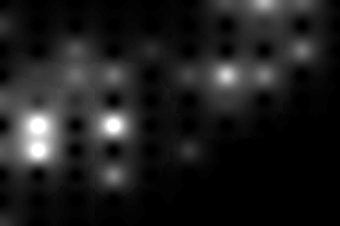

In [54]:
testrast=arcpy.Raster(root + "/" + "IDW"+str(1))+3*arcpy.Raster(root + "/" + "IDW"+str(15))
testrast_name=root+"/"+"testrast"
if arcpy.Exists(testrast_name):
    arcpy.Delete_management(testrast_name)
testrast.save(testrast_name)
testrast

1.0
0.9375
0.875
0.8125
0.75
0.6875
0.625
0.5625
0.5
0.4375
0.375
0.3125
0.25
0.1875
0.125
0.0625


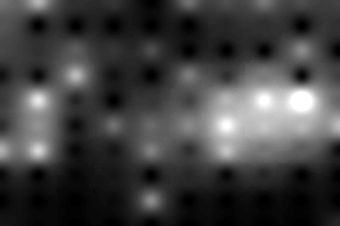

In [65]:
itt=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
rastfin=0
n=1/16
for j in itt:
    rastfin=rastfin+(1+n-j*n)*arcpy.Raster(root + "/" + "IDW"+str(j))
rastfin_name=root+"/"+"testrast"
if arcpy.Exists(rastfin_name):
    arcpy.Delete_management(rastfin_name)
rastfin.save(testrast_name)
rastfin
    

In [92]:
lat="1,9"
long="47,86"
name=lat+" "+long
print(name)
result_loc = arcpy.GetCellValue_management(rastfin, name)
value=result_loc.getOutput(0)
Valuechg=value.replace(",",".")
Valuefloat=float(Valuechg)

if Valuefloat>1.0:
    print("Humid soil")
else:
    print("dry soil")

1,9 47,86
Humid soil


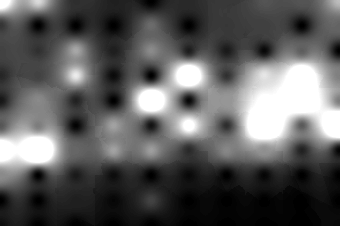

In [118]:
rastfin

#arcpy.Raster(root + "/" + "IDW"+str(8))

In [7]:
arcpy.DeleteField_management("fishnet_w_coords", "Add_")

<Result 'C:/EsriTraining/RUDN2/dorianpro.gdb\\fishnet_w_coords'>

In [10]:
sites_layer = arcpy.env.workspace + "/fishnet_w_coords"
#get all field names
fields = arcpy.ListFields(sites_layer)
#print(fields) #not understandable

for field in fields:
    print(field.name)

OBJECTID_1
Shape
OBJECTID
POINT_X
POINT_Y
Shape_Length
Shape_Area
Rain_amount
Rain_amount2
Rain_amount3
Rain_amount_48h
Rain_amount_45h
Rain_amount_42h
Rain_amount_39h
Rain_amount_36h
Rain_amount_33h
Rain_amount_30h
Rain_amount_27h
Rain_amount_24h
Rain_amount_21h
Rain_amount_18h
Rain_amount_15h
Rain_amount_12h
Rain_amount_9h
Rain_amount_6h
Rain_amount_3h


In [13]:
arcpy.AddField_management("fishnet_w_coords","Rain_amount_6h","FLOAT")

<Result 'C:/EsriTraining/RUDN2/dorianpro.gdb\\fishnet_w_coords'>

In [19]:
arcpy.AlterField_management("fishnet_w_coords","Add_","Rain_amount_6h")

<Result 'C:/EsriTraining/RUDN2/dorianpro.gdb\\fishnet_w_coords'>

In [41]:
layerfields=["*"]
with arcpy.da.SearchCursor(sites_layer,layerfields) as cursor:
    for row in cursor:
        print(row)

(1, (-4.408542775999962, 41.82153396600006), 1, -4.408542775999933, 41.82153396600006, 4.89196262400003, 1.4344864795991636, 0.3799999952316284, 0.0, 0.10999999940395355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12999999523162842)
(2, (-2.938126039499963, 41.82153396600006), 2, -2.938126039999929, 41.82153396600006, 4.891962626000009, 1.434486480574718, 0.6600000262260437, 0.0, 0.11999999731779099, 0.0, 0.0, 0.0, 0.0, 0.10999999940395355, 0.10999999940395355, 0.10999999940395355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(3, (-1.467709302999964, 41.82153396600006), 3, -1.4677093029999355, 41.82153396600006, 4.89196262400003, 1.4344864795991636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
(4, (0.0027074335000348837, 41.82153396600006), 4, 0.0027074340000581287, 41.82153396600006, 4.891962626000009, 1.434486480574718, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [83]:
owm = pyowm.OWM('3ac4af53f33d1bb8a67da2676052a1a6')
fc = owm.three_hours_forecast("Olivet")
result_rain=fc.will_have_rain()
result_rain

True